In [1]:
#!pip install pandas
#!pip install matplotlib
#!pip install scikit-image

# Importamos librerías
import zipfile
import pandas as pd
import numpy as np
from io import BytesIO
from matplotlib import pyplot as plt
import math
from scipy.signal import find_peaks
from skimage.util import view_as_windows

import json
from collections import defaultdict

In [2]:
file_path = '/home/maria/Escritorio/TI/DatosSinapsisArtificial'

In [3]:
def zip_to_dataframe(file_path, file_name, names):
    file_path_zip = f'{file_path}/{file_name}.zip'
    file_name_txt = f'{file_name}.txt'
    with zipfile.ZipFile(file_path_zip) as thezip:
        with thezip.open(file_name_txt, mode='r') as thefile:
            data = thefile.read()
            return pd.read_csv(BytesIO(data), sep = '\t', index_col = False, names = names, skiprows=range(3), decimal = ',')

# Análisis CONTROL (TrozoC)

In [4]:
filename = 'TrozoC'
names = ['LP','VD']
trozoC = zip_to_dataframe(file_path, filename, names)

In [5]:
print('Number of channels = ', len(trozoC.columns)) # 2
print('Number of samples per channel = ', len(trozoC)) # 19847700
trozoC.head()

Number of channels =  2
Number of samples per channel =  19847700


,LP,VD
0,0.004883,0.015259
1,0.001526,0.024109
2,-0.010681,0.031128
3,-0.022278,0.041809
4,-0.028076,0.045471


Representar los datos teniendo en cuenta que las señales se midieron cada 0.1 s.

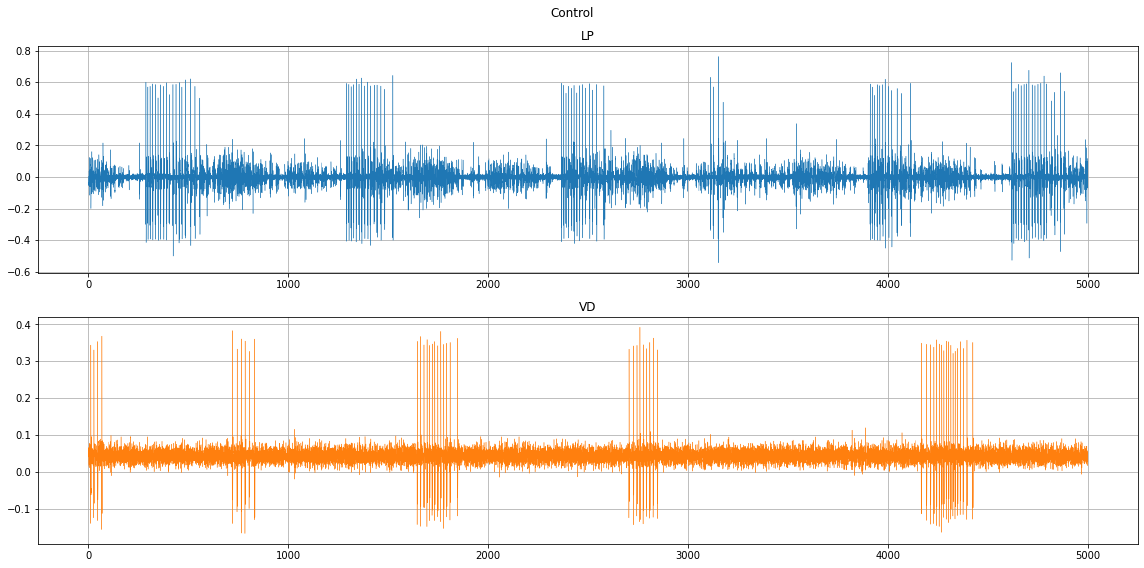

In [6]:
n = 50000
dt = 0.1
t = np.arange(0, n*dt, dt)
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_size_inches(16, 8)
fig.suptitle('Control')

ax1.grid(True)
ax1.plot(t,trozoC['LP'].iloc[:n],lw=0.4)
ax1.set_title("LP")

ax2.plot(t,trozoC['VD'].iloc[:n],'tab:orange',lw=0.4)
ax2.set_title("VD")
ax2.grid(True)

fig.tight_layout()

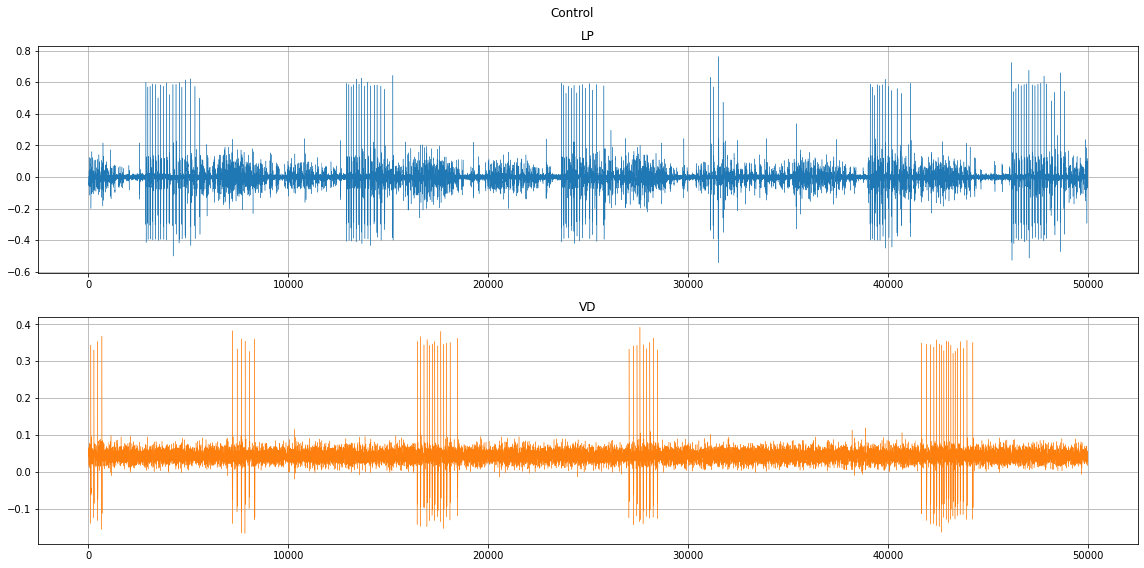

In [7]:
n = 50000
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_size_inches(16, 8)
fig.suptitle('Control')

ax1.plot(trozoC['LP'].iloc[:n],lw=0.4)
ax1.set_title("LP")
ax1.grid(True)

ax2.plot(trozoC['VD'].iloc[:n],'tab:orange',lw=0.4)
ax2.set_title("VD")
ax2.grid(True)

fig.tight_layout()

## Detección de Spikes

#### Utilizando método estadístico

In [8]:
trozoC.describe()

,LP,VD
count,1.984770e+07,1.984770e+07
mean,-2.253853e-08,4.385849e-02
std,8.214042e-02,3.287948e-02
min,-7.101440e-01,-2.170715e+00
25%,-2.288800e-02,3.295900e-02
50%,3.050000e-04,4.364000e-02
75%,2.410900e-02,5.401600e-02
max,9.344480e-01,1.351624e+00


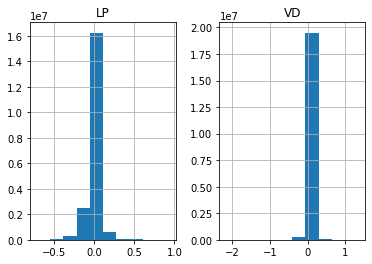

In [10]:
histogram = trozoC.hist()
plt.show()

In [11]:
def my_ceil(a, precision=0):
    return np.round(a + 0.5 * 10**(-precision), precision)

def get_threshold(df):
    return my_ceil(df.mean() + 4.5*df.std(),2)

In [12]:
threshold = get_threshold(trozoC)
threshold

LP    0.37
VD    0.20
dtype: float64

#### Utilizando la propia función de scipy

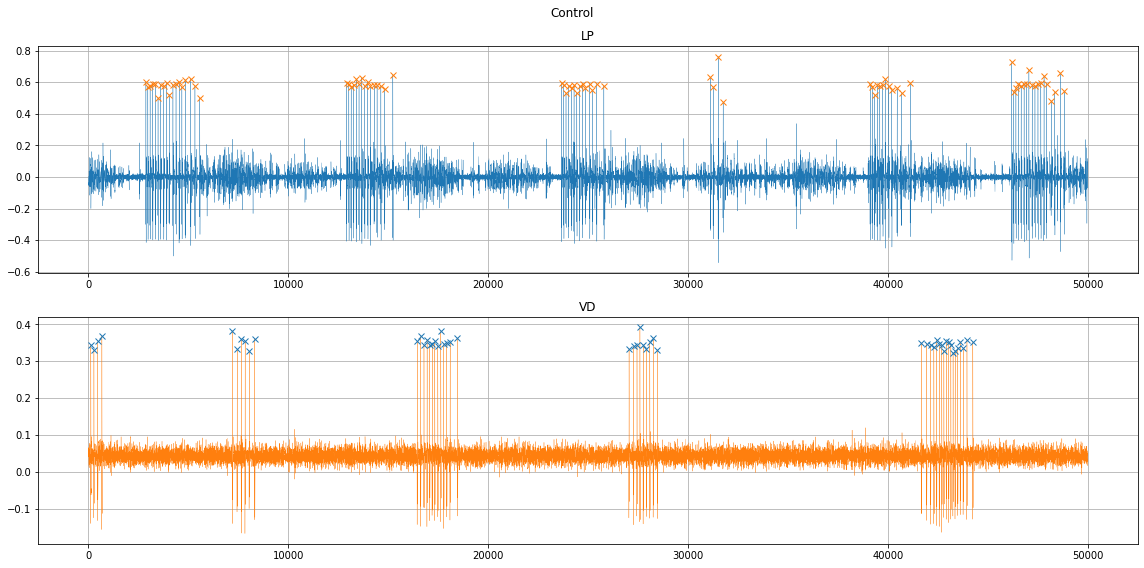

In [13]:
n = 50000
peaks_clp, _ = find_peaks(trozoC.LP[:n], threshold[0])
peaks_cvd, _ = find_peaks(trozoC.VD[:n], threshold[1])

fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_size_inches(16, 8)
fig.suptitle('Control')

ax1.plot(trozoC.LP[:n],lw=0.3)
ax1.plot(peaks_clp, trozoC.LP[:n][peaks_clp], "x")
ax1.set_title("LP")
ax1.grid(True)

ax2.plot(trozoC.VD[:n],'tab:orange',lw=0.3)
ax2.plot(peaks_cvd, trozoC.VD[:n][peaks_cvd], "x")
ax2.set_title("VD")
ax2.grid(True)

fig.tight_layout()

In [14]:
clp_spikes,_ = find_peaks(trozoC.LP, threshold[0])
cvd_spikes,_ = find_peaks(trozoC.VD, threshold[1])

In [15]:
# Spikes totales por señal
print(len(clp_spikes))
print(len(cvd_spikes))

31231
22335


### Distancia entre spikes

In [16]:
clp_distances = np.diff(clp_spikes)

print('Min = ', np.amin(clp_distances))
print('Max = ',np.amax(clp_distances))
print('Mean = ',np.mean(clp_distances))
print('Medium = ',np.median(clp_distances))
print('Q1 = ',np.quantile(clp_distances, 0.00025))

Min =  3
Max =  22323
Mean =  635.3495036823567
Medium =  154.0
Q1 =  24.80725


In [17]:
cvd_distances = np.diff(cvd_spikes)

print('Min = ', np.amin(cvd_distances))
print('Max = ',np.amax(cvd_distances))
print('Mean = ',np.mean(cvd_distances))
print('Medium = ',np.median(cvd_distances))
print('Q1 = ',np.quantile(cvd_distances, 0.00025))

Min =  4
Max =  29910
Mean =  888.3783469150175
Medium =  160.0
Q1 =  17.1665


# ESTO NO SE SI ELIMINARLO

In [17]:
# Eliminamos aquellos spikes que esten a una distancia menos que la distancia del quartil 0.00025
q1_clp = np.quantile(clp_distances, 0.00025)
clp_spikes, _ = find_peaks(trozoC.LP,height=threshold[0], distance=q1_clp)
clp_distance = np.diff(clp_spikes)

q1_cvd = np.quantile(cvd_distances, 0.00025)
cvd_spikes, _ = find_peaks(trozoC.VD,height=threshold[0], distance=q1_cvd)
cvd_distance = np.diff(cvd_spikes)

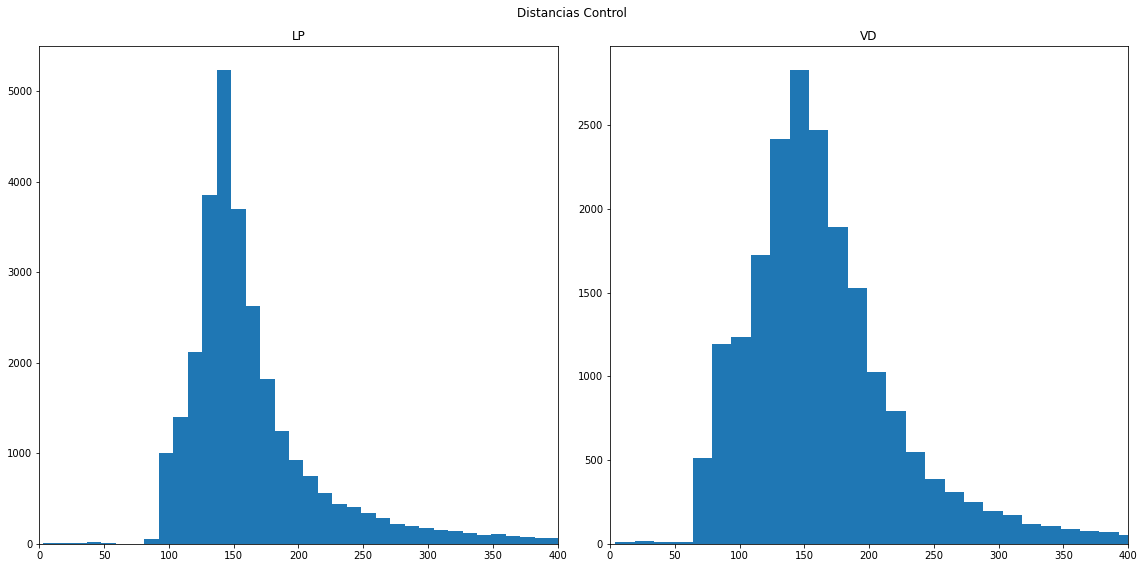

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(16, 8)
fig.suptitle('Distancias Control')

ax1.hist(clp_distances,bins=2000)
ax1.set_xlim((0, 400))
ax1.set_title("LP")


ax2.hist(cvd_distances,bins=2000)
ax2.set_title("VD")
ax2.set_xlim((0, 400))

fig.tight_layout()

### Discretización

In [20]:
trozoC['LP_events'] = 0
trozoC.LP_events[clp_spikes] = 1
trozoC['VD_events'] = 0
trozoC.VD_events[cvd_spikes] = 1

/tmp/ipykernel_35357/3004514755.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trozoC.LP_events[clp_spikes] = 1
/tmp/ipykernel_35357/3004514755.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trozoC.VD_events[cvd_spikes] = 1


In [21]:
trozoC.head()

,LP,VD,LP_events,VD_events
0,0.004883,0.015259,0,0
1,0.001526,0.024109,0,0
2,-0.010681,0.031128,0,0
3,-0.022278,0.041809,0,0
4,-0.028076,0.045471,0,0


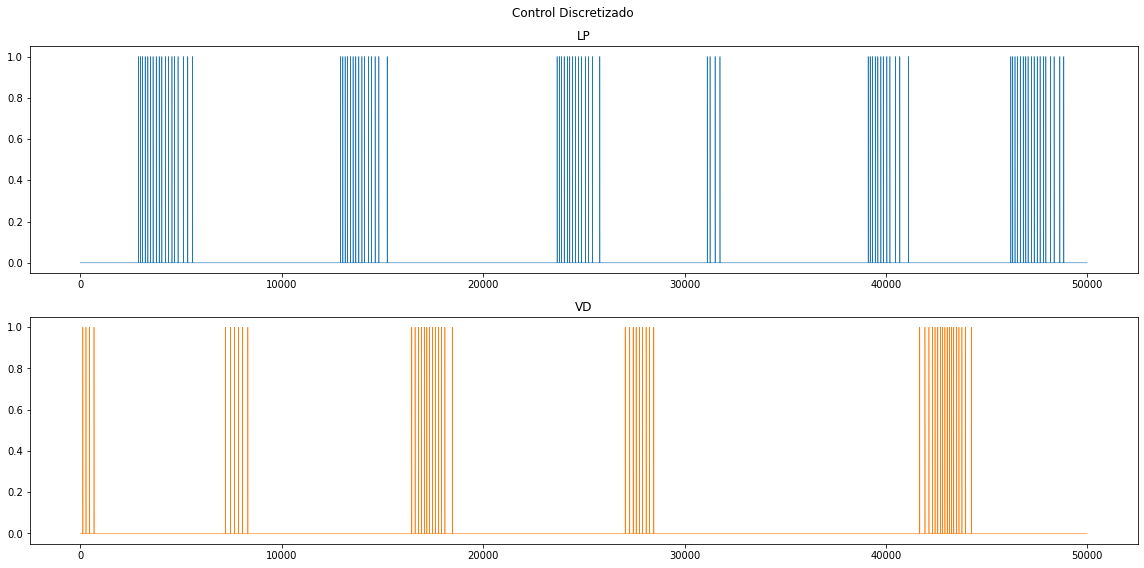

In [22]:
n = 50000

fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_size_inches(16, 8)
fig.suptitle('Control Discretizado')

ax1.plot(trozoC.LP_events.iloc[:n],lw=0.6)
ax1.set_title("LP")

ax2.plot(trozoC.VD_events.iloc[:n],'tab:orange',lw=0.6)
ax2.set_title("VD")

fig.tight_layout()

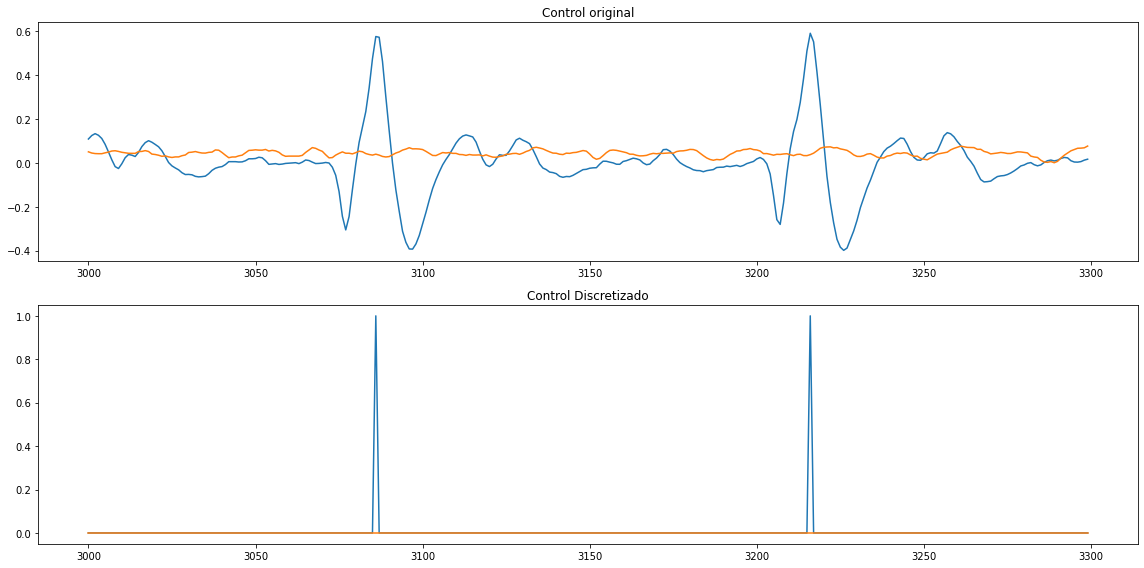

In [23]:
#Momento en el que se ve un spike!
i = 3000
f = 3300

fig, (ax1, ax2) = plt.subplots(2,1)
fig.set_size_inches(16, 8)
#fig.suptitle('Control Discretizado')

ax1.plot(trozoC['LP'].iloc[i:f])
ax1.plot(trozoC['VD'].iloc[i:f])
ax1.set_title("Control original")


ax2.plot(trozoC['LP_events'].iloc[i:f])
ax2.plot(trozoC['VD_events'].iloc[i:f],'tab:orange')
ax2.set_title("Control Discretizado")

fig.tight_layout()

### Tamaño de ventana

In [24]:
def get_errors_rate(series, bin_sizes):
    errors_rate = []
    for bin_size in bin_sizes:
        bins_spikes = view_as_windows(series,window_shape=bin_size, step=bin_size).sum(axis=1)
        errors_rate.append((bins_spikes>1).sum()/len(series))
    return np.array(errors_rate)

In [25]:
bin_sizes = range(1,150)
clp_errors = get_errors_rate(np.array(trozoC.LP_events),bin_sizes)
cvd_errors = get_errors_rate(np.array(trozoC.VD_events),bin_sizes)

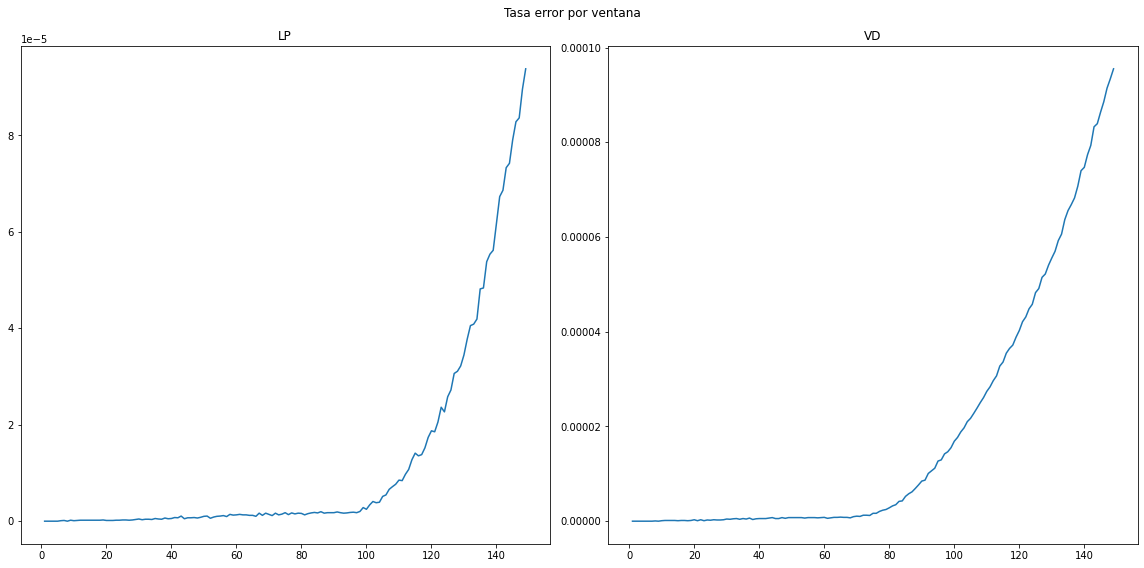

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(16, 8)
fig.suptitle('Tasa error por ventana')

ax1.plot(bin_sizes,clp_errors)
ax1.set_title("LP")

ax2.plot(bin_sizes,cvd_errors)
ax2.set_title("VD")


fig.tight_layout()

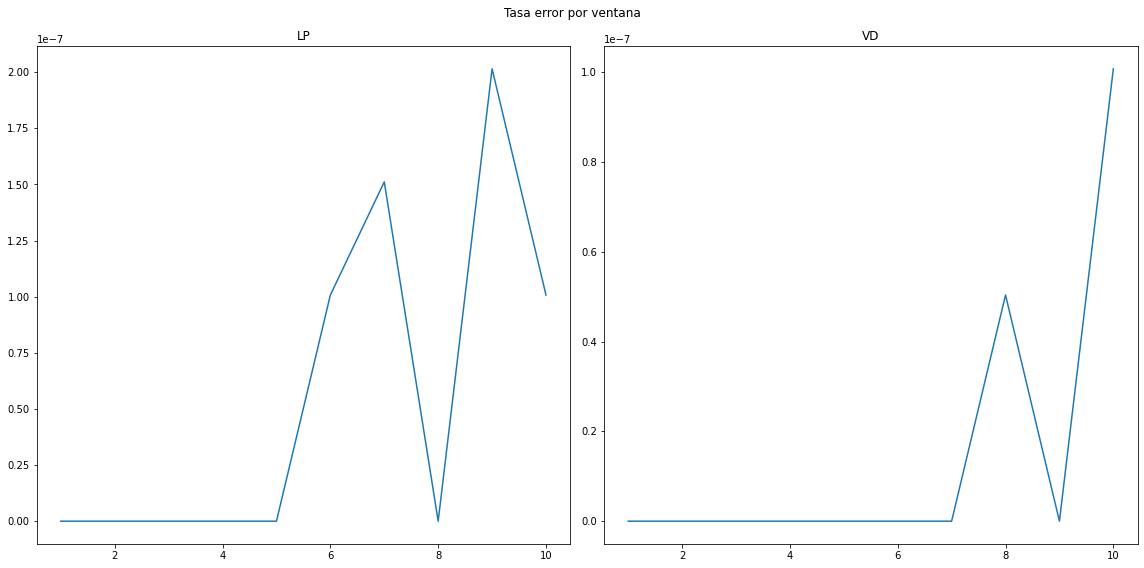

In [27]:
n = 10
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(16, 8)
fig.suptitle('Tasa error por ventana')

ax1.plot(bin_sizes[:n],clp_errors[:n])
ax1.set_title("LP")

ax2.plot(bin_sizes[:n],cvd_errors[:n])
ax2.set_title("VD")


fig.tight_layout()

### Analisis de ventanas

In [29]:
def to_words(series, nbits, nsteps):
    if nbits == 1:
        return np.array(list(map(str,series)))
    else:
        series_bin = view_as_windows(np.array(series),window_shape=nbits, step=nsteps)
        return np.array([''.join(map(str,bins)) for bins in series_bin])

def prob(x): # x : np of str (words)
    keys, counts = np.unique(x, return_counts=True)
    return dict(zip(keys,counts/len(x)))

def joint_prob(x, y):  # x,y : np of str (words)
    xy = list(map('|'.join,zip(x, y)))
    keys, counts = np.unique(xy, return_counts=True)
    return dict(zip(keys,counts/len(x)))

def entropy(x): # x : dict of probabilities
    return - np.sum([w * np.log2(w) for w in x.values()])
    
def MI(x, y): # x,y : np of str (words)
    px, py, pxy = prob(x),prob(y),joint_prob(x,y)
    ex, ey = entropy(px), entropy(py)
    mi=0
    for k in pxy:
        kx, ky = k.split('|')
        mi += pxy[k] * np.log2(pxy[k]/(px[kx] * py[ky]))
    return mi,ex, ey

#### Ejemplo: tamaño de ventana = 1 & tamaño de palabras = 1

In [30]:
nbits = 1
    
clp_words_1 = to_words(trozoC.LP_events, nbits, nbits)
cvd_words_1 = to_words(trozoC.VD_events, nbits, nbits)

In [31]:
prob_clp_1,prob_cvd_1 = prob(clp_words_1),prob(cvd_words_1)
print("Probabilidades Control LP con 1 bit: \n{0}".format(json.dumps(prob_clp_1,sort_keys=True, indent=2)))
print("\nProbabilidades Control VD con 1 bit: \n{0}".format(json.dumps(prob_cvd_1,sort_keys=True, indent=2)))
joint_prob_1 = joint_prob(clp_words_1,cvd_words_1)
print("\nProbabilidades Conjuntas Control LP y VD con 1 bit: \n{0}".format(json.dumps(joint_prob_1,sort_keys=True, indent=2)))
mi_1, e_clp_1, e_cvd_1 = MI(clp_words_1,cvd_words_1)
print("\nEntropía Control LP con 1 bit: {0}".format(e_clp_1))
print("\nEntropía Control VD con 1 bit: {0}".format(e_cvd_1))
print("\nInformación Mutua Control LP y VD con 1 bit: {0}".format(mi_1))

Probabilidades Control LP con 1 bit: 
{
  "0": 0.9984264675503962,
  "1": 0.0015735324496037324
}

Probabilidades Control VD con 1 bit: 
{
  "0": 0.9988746806934808,
  "1": 0.0011253193065191432
}

Probabilidades Conjuntas Control LP y VD con 1 bit: 
{
  "0|0": 0.9973011986275487,
  "0|1": 0.0011252689228474836,
  "1|0": 0.0015734820659320727,
  "1|1": 5.038367165968853e-08
}

Entropía Control LP con 1 bit: 0.01692072429498008

Entropía Control VD con 1 bit: 0.012645587614367295

Información Mutua Control LP y VD con 1 bit: 2.2264567559197284e-06


In [ ]:
bin_sizes = range(1,81)
lp_bins, vd_bins = {}, {}
for bin_size in bin_sizes:
        lp_bins[bin_size] = view_as_windows(np.array(trozoC.LP_events),window_shape=bin_size, step=bin_size).sum(axis=1)
        vd_bins[bin_size] = view_as_windows(np.array(trozoC.VD_events),window_shape=bin_size, step=bin_size).sum(axis=1)

### Palabras 1 bit

In [37]:
bin_sizes = range(1,81)
nbits = 1
mi, elp, evd = [], [], []
for bin_size in bin_sizes:
    lp_words = to_words(lp_bins[bin_size], nbits, nbits)
    vd_words = to_words(vd_bins[bin_size], nbits, nbits)
    m_i, e_lp, e_vd = MI(lp_words,vd_words)
    mi.append(m_i)
    elp.append(e_lp)
    evd.append(e_vd)
mi = np.array(mi)
elp = np.array(elp)
evd = np.array(evd)
ti_lp_vd = mi/elp
ti_vd_lp = mi/evd

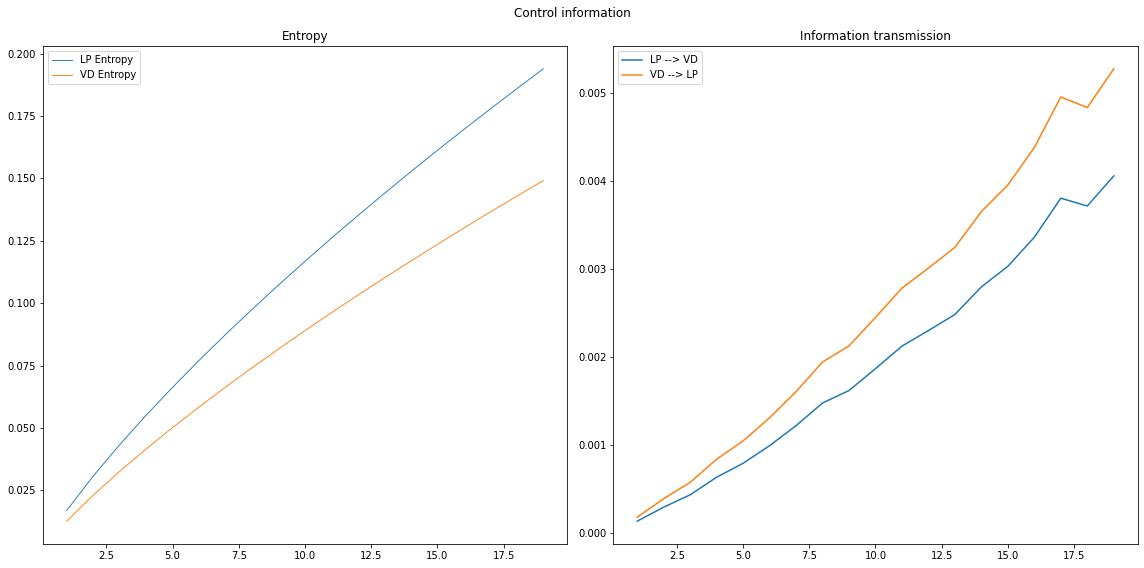

In [46]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(16, 8)
fig.suptitle(f'Control information (1 bit)')

ax1.plot(bin_sizes,mi,lw=0.9)
ax1.set_title("MI")
ax1.set_xlabel("Tamaño de ventana")


ax2.plot(bin_sizes,elp,lw=0.9,label='LP Entropy')
ax2.plot(bin_sizes,evd,'tab:orange',label='VD Entropy',lw=0.9)
ax2.set_title("Entropy")
ax2.set_xlabel("Tamaño de ventana")
ax2.legend()

ax3.plot(bin_sizes,ti_lp_vd, label = 'LP --> VD')
ax3.plot(bin_sizes,ti_vd_lp,label = 'VD --> LP')
ax3.set_title('Information transmission')
ax3.set_xlabel("Tamaño de ventana")
ax3.legend()

fig.tight_layout()

### Para cada tamaño de palabra

In [54]:
bin_sizes = range(1,81)
nbits_size = range(1,9)
mi, elp, evd, ti_lp_vd, ti_vd_lp  = {},{},{},{},{}
for nbits in nbits_size:
    mi_l, elp_l, evd_l = [], [], []
    for bin_size in bin_sizes:
        lp_words = to_words(lp_bins[bin_size], nbits, nbits)
        vd_words = to_words(vd_bins[bin_size], nbits, nbits)
        m_i, e_lp, e_vd = MI(lp_words,vd_words)
        mi_l.append(m_i)
        elp_l.append(e_lp)
        evd_l.append(e_vd)
    mi[nbits] = np.array(mi_l)
    elp[nbits] = np.array(elp_l)
    evd[nbits] = np.array(evd_l)
    ti_lp_vd[nbits] = np.array(mi_l)/np.array(elp_l)
    ti_vd_lp[nbits] = np.array(mi_l)/np.array(evd_l)

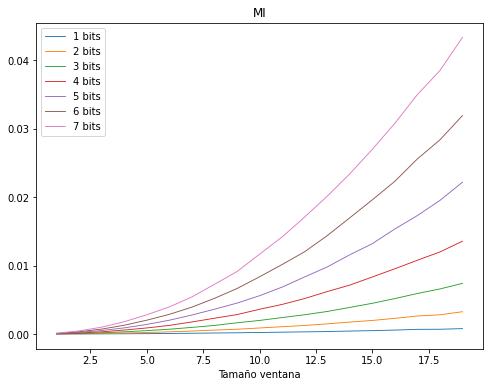

In [56]:
plt.figure(figsize=(8, 6))
plt.title("MI")
plt.xlabel("Tamaño ventana")
for nbits in nbits_size:
    plt.plot(bin_sizes,mi[nbits], label = f"{nbits} bits")
plt.legend()
plt.show()

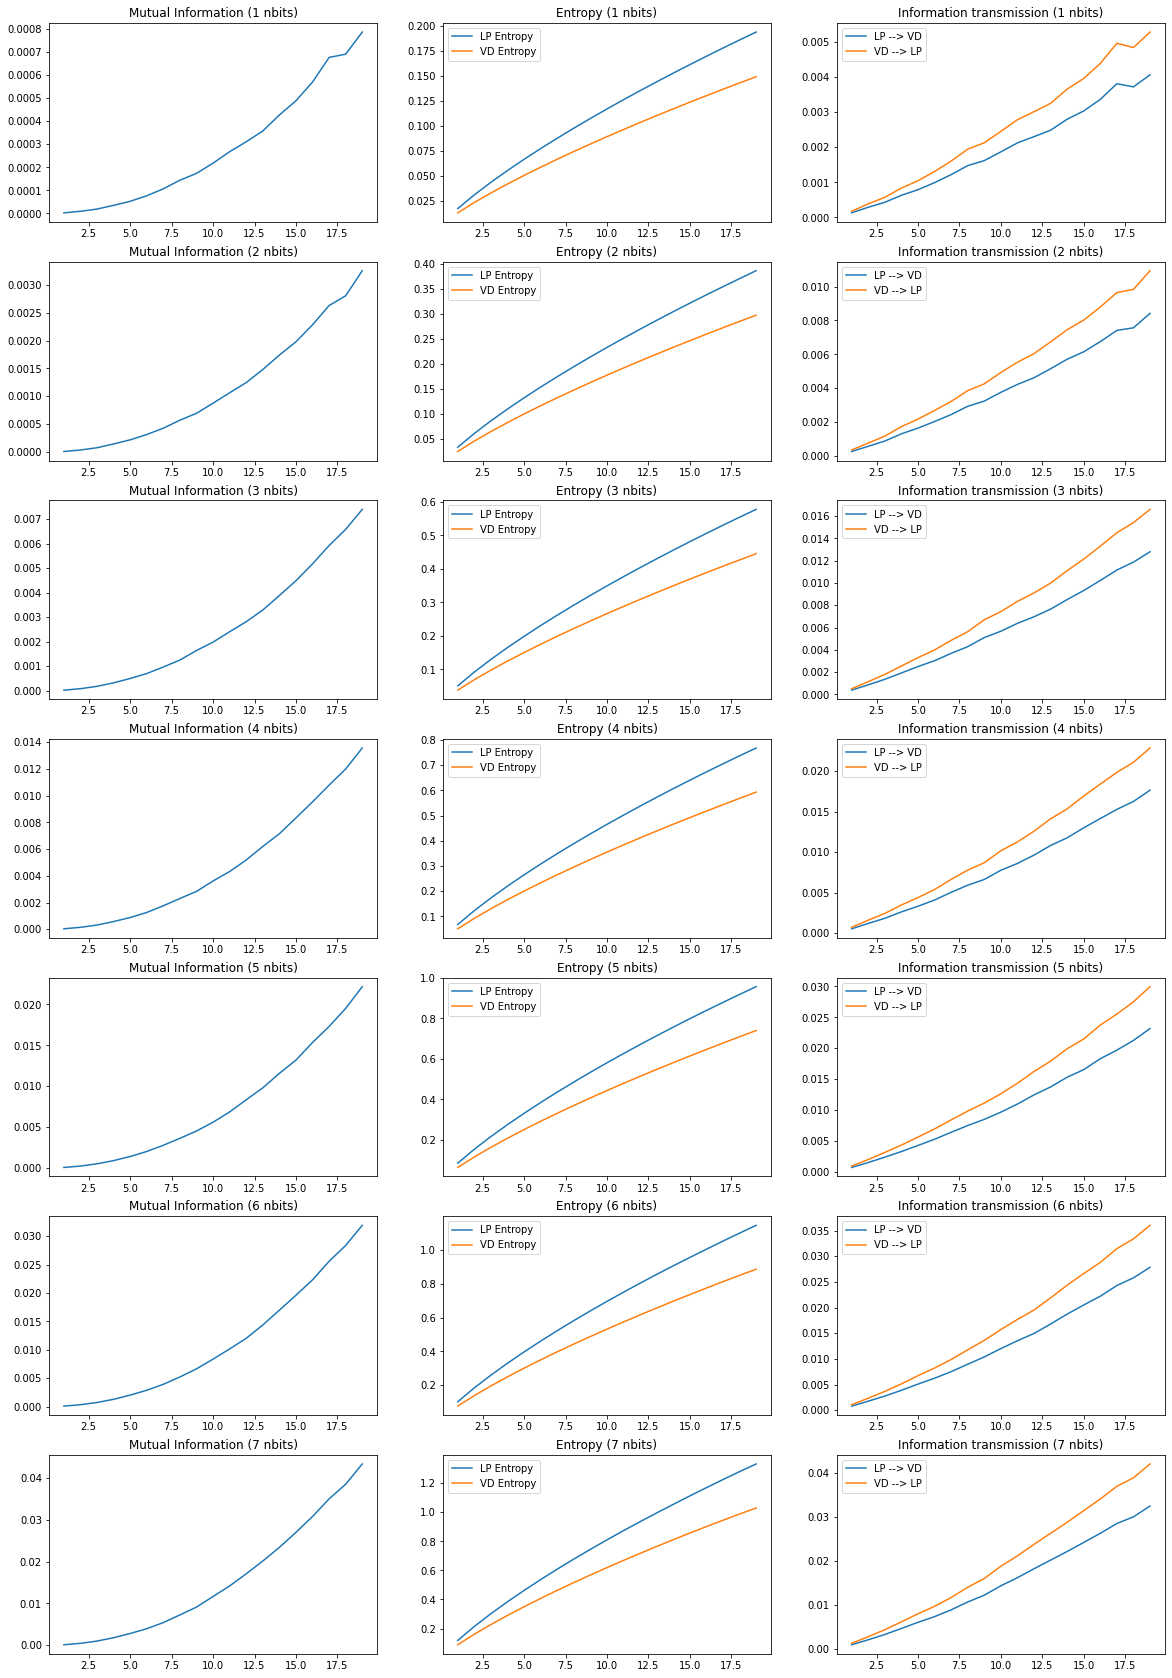

In [67]:
fig, axes = plt.subplots(len(nbits_size), 3, figsize=(20, 30))

for nbits,row in enumerate(axes):
    x = np.random.normal(0, 1, 100).cumsum()
    y = np.random.normal(0, 0.5, 100).cumsum()
    row[0].plot(bin_sizes,mi[nbits+1])
    row[0].set_title(f"Mutual Information ({nbits+1} nbits)")

    row[1].plot(bin_sizes,elp[nbits+1],label='LP Entropy')
    row[1].plot(bin_sizes,evd[nbits+1],label='VD Entropy')
    row[1].set_title(f"Entropy ({nbits+1} nbits)")
    row[1].legend()
    
    row[2].plot(bin_sizes,ti_lp_vd[nbits+1],label = 'LP --> VD')
    row[2].plot(bin_sizes,ti_vd_lp[nbits+1],label = 'VD --> LP')
    row[2].set_title(f'Information transmission ({nbits+1} nbits)')
    row[2].legend()
    
plt.show()

### Codificación palabras con desplazamiento solapantes

In [ ]:
bin_sizes = range(1,81)
nbits_size = range(1,9)
mi_s, elp_s, evd_s, ti_lp_vd_s, ti_vd_lp_s  = {},{},{},{},{}
for nbits in nbits_size:
    mi_l, elp_l, evd_l = [], [], []
    for bin_size in bin_sizes:
        lp_words = to_words(lp_bins[bin_size], nbits, 1)
        vd_words = to_words(vd_bins[bin_size], nbits, 1)
        m_i, e_lp, e_vd = MI(lp_words,vd_words)
        mi_l.append(m_i)
        elp_l.append(e_lp)
        evd_l.append(e_vd)
    mi_s[nbits] = np.array(mi_l)
    elp_s[nbits] = np.array(elp_l)
    evd_s[nbits] = np.array(evd_l)
    ti_lp_vd_s[nbits] = np.array(mi_l)/np.array(elp_l)
    ti_vd_lp_s[nbits] = np.array(mi_l)/np.array(evd_l)

In [ ]:
plt.figure(figsize=(8, 6))
plt.title("MI")
plt.xlabel("Tamaño ventana")
for nbits in nbits_size:
    plt.plot(bin_sizes,mi_s[nbits], label = f"{nbits} bits")
plt.legend()
plt.show()

In [ ]:
fig, axes = plt.subplots(len(nbits_size), 3, figsize=(20, 30))

for nbits,row in enumerate(axes):
    x = np.random.normal(0, 1, 100).cumsum()
    y = np.random.normal(0, 0.5, 100).cumsum()
    row[0].plot(bin_sizes,mi_s[nbits+1])
    row[0].set_title(f"Mutual Information ({nbits+1} nbits)")

    row[1].plot(bin_sizes,elp_s[nbits+1],label='LP Entropy')
    row[1].plot(bin_sizes,evd_s[nbits+1],label='VD Entropy')
    row[1].set_title(f"Entropy ({nbits+1} nbits)")
    row[1].legend()
    
    row[2].plot(bin_sizes,ti_lp_vd_s[nbits+1],label = 'LP --> VD')
    row[2].plot(bin_sizes,ti_vd_lp_s[nbits+1],label = 'VD --> LP')
    row[2].set_title(f'Information transmission ({nbits+1} nbits)')
    row[2].legend()
    
plt.show()